In [13]:
# Import all libraries and modules
import pandas as pd
import numpy as np

# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
from matplotlib import rc
from cycler import cycler

## Transformation - SMOTE, Downsampling, Scaling
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from sklearn.svm import SVC
from sklearn.utils import resample 

## Deep Learning Keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

# Model Performance Evaluation
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.metrics import precision_recall_curve, auc

import pickle

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import time

import shap
import lime
import lime.lime_tabular

import os
print('Libraries imported successfully')


Libraries imported successfully


In [5]:
# set the style for the notebook, in this case colorblind, alternative would be grayscale
sns.set_palette("colorblind")

# Alternative Custom Grayscale
# grayscale_palette = ['black', '0.8', '0.6', '0.4', '0.2', '0.1', '0.7', '0.3']
# Set the grayscale palette
# sns.set_palette(grayscale_palette)

# Set APA style parameters for matplotlib
plt.rcParams.update({
    'font.family': 'sans-serif',
    'figure.titlesize': 'large',
    'figure.titleweight': 'bold',
    'figure.subplot.wspace': 0.3,
    'figure.subplot.hspace': 0.3,
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.labelcolor': 'black',
    'axes.autolimit_mode': 'round_numbers',
    'axes.axisbelow': 'line',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'axes.labelpad': 5.0,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.bottom': True,
    'axes.spines.left': True,
    'axes.grid': False,
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'errorbar.capsize': 10,
    'savefig.format': 'svg',
    'savefig.bbox': 'tight'
})
    
# Define various cyclers
grayscale_color_cycle = cycler('color', ['black', '0.8', '0.6', '0.4', '0.2', '0.1', '0.7', '0.3'])
linestyle_cycle = cycler('linestyle', ['-', '--', '-.', ':', '-', '--', '-.', ':'])
linewidth_cycle = cycler('linewidth', [1.2, 1.2, 1, 0.7, 0.5, 1, 0.8, 0.6])
hatch_cycle = cycler('hatch', ['/', '\\', '|', '-', '+', 'x', 'o', 'O'])
combined_cycle = grayscale_color_cycle + linestyle_cycle + linewidth_cycle + hatch_cycle
    
# Set the style for seaborn plots
sns.set_style("white", rc={
    "font.family": "sans-serif",
    "axes.facecolor": "white",
    "axes.edgecolor": "black",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.prop_cycle": combined_cycle
})

In [6]:
# set the file paths
# Define the path for saving the figures
figures_folder = '../reports/figures' 
# Define the path for saving the models
models_folder = '../models'

In [9]:
# Reading MIT-BIH Arrhythmia Dataset 
df = pd.read_csv('MIT-BIH Arrhythmia Database.csv') 

unique_types = df['type'].unique()
print(unique_types)
print(df.shape)

#Remove Unknown beats 
#df = df[df['type'] != 'Q']

# Create binary target variable 
df['type'].value_counts()
class_mapping_lambda = lambda x: 0 if x == 'N' else 1
df['label'] = df['type'].apply(class_mapping_lambda)

# Print the value counts of the new 'class' column
print(df['label'].value_counts())
df.drop(['type', 'record'], axis=1, inplace=True)

df.head(10)

['N' 'Q' 'SVEB' 'VEB' 'F']
(100689, 34)
label
0    90083
1    10606
Name: count, dtype: int64


,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,0_pq_interval,0_qt_interval,...,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4,label
0,76,313.0,0.074347,-0.160548,1.036401,-0.285662,-0.026824,41,18,66,...,2,18,22,2,0.025930,0.025930,0.025930,0.025436,0.025436,0
1,313,315.0,-0.052079,-0.264784,0.886597,-0.366298,-0.059710,21,4,33,...,26,27,62,9,-0.042009,-0.029498,0.005012,0.030892,0.002986,0
2,315,321.0,-0.062151,-0.296983,0.991859,-0.410306,-0.065686,22,3,32,...,3,8,12,1,0.009528,0.009528,0.008786,0.008786,0.008368,0
3,321,336.0,-0.063322,-0.281386,1.034903,-0.403880,-0.071750,22,4,33,...,6,9,16,1,-0.020536,-0.020257,-0.018965,-0.016968,-0.014555,0
4,336,344.0,-0.062915,1.046914,1.046408,1.046408,-0.074639,11,4,16,...,16,5,31,10,0.016053,0.006742,0.002782,-0.007798,-0.051155,0
5,344,324.0,-0.083040,-0.293023,0.931546,-0.433485,-0.088745,22,3,33,...,8,10,19,1,-0.036339,-0.034673,-0.026985,-0.022147,-0.013531,0
6,324,313.0,-0.067520,-0.286934,1.050545,-0.482886,-0.074666,23,3,34,...,27,10,45,8,-0.032788,-0.017467,0.013925,0.035176,0.016576,0
7,313,313.0,-0.085844,-0.341904,1.154904,-0.439149,-0.094663,22,3,31,...,8,2,21,11,-0.008229,-0.011703,-0.024895,-0.034285,-0.054572,0
8,313,310.0,-0.061510,-0.257011,1.107787,-0.385508,-0.065044,25,5,37,...,21,31,61,9,-0.029834,-0.020603,0.004411,0.025997,0.015942,0
9,310,329.0,-0.063513,-0.319736,1.087343,-0.425738,-0.074461,22,4,32,...,15,2,26,9,0.018915,0.010747,0.000927,-0.018538,-0.060157,0


# Preprocessing: Downscaling, train test splot and scaling of features

In [10]:
# Separate features and target variable
X = df.drop(['label'], axis=1)  # Features
y = df['label']  # Target variable

# Split the dataset into 80% training20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save original training dataset for later reference
X_train_original = X_train
y_train_original = y_train

# Scaling of features 
scaler = preprocessing.MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(scaler.scale_)

[0.00047551 0.00047438 0.14460252 0.163272   0.15645161 0.13086489
 0.14384207 0.00588235 0.00671141 0.00303951 0.00714286 0.14384207
 0.18186031 0.16202895 0.16077164 0.17486125 0.00047551 0.00047438
 0.13755979 0.10530541 0.12858414 0.10556911 0.11260797 0.00384615
 0.00543478 0.002457   0.0046729  0.11260797 0.12377001 0.1410501
 0.15095282 0.13532692]


# Downsampling 

In [11]:
# Separate majority and minority classes in original data
majority_class = df[df['label'] == 0]
minority_class = df[df['label'] == 1]

# Downsample the majority class
downsampled_majority = resample(majority_class, 
                                replace=False,    # Sample without replacement
                                n_samples=len(minority_class),  # Match minority class size
                                random_state=42)  # Reproducible results

# Combine minority class with downsampled majority class
balanced_df = pd.concat([downsampled_majority, minority_class])

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42)

# Check the class distribution
print(balanced_df['label'].value_counts())

# Further downsample the balanced dataset
downsampled_balanced = resample(balanced_df, 
                         replace=False,    # Sample without replacement
                                n_samples=10000,  # Set desired size
                                random_state=42)  # Reproducible results

# Shuffle the downsampled dataset
downsampled_balanced = downsampled_balanced.sample(frac=1, random_state=42)

# Check the class distribution
print(downsampled_balanced['label'].value_counts())

# Splitting the dataset into features (X) and labels (y)
X_train_ds = downsampled_balanced.drop(columns=['label'])
y_train_ds = downsampled_balanced['label']

# Print the shapes of the resulting sets
print("Shape of X_train after downsampling:", X_train_ds.shape)
print("Shape of y_train after downsampling:", y_train_ds.shape)

X_train = X_train_ds
y_train = y_train_ds

label
1    10606
0    10606
Name: count, dtype: int64
label
0    5047
1    4953
Name: count, dtype: int64
Shape of X_train after downsampling: (10000, 32)
Shape of y_train after downsampling: (10000,)


# Deep Learning 

# Dense Neural Networks - Comparison of different activation functions

In [12]:
# Set random seed for TensorFlow/Keras
tf.random.set_seed(42)

In [14]:
# Define the list of activation functions to compare
activation_functions = ["relu", "sigmoid", "tanh"]

# Create a dictionary to store classification reports and confusion matrices
results_dnn = {}

# Create a dictionary to store trained models
trained_models = {}

# Iterate over each activation function
for activation_func in activation_functions:
    # Build the DNN model
    inputs = Input(shape=(32,), name="Input")
    dense1 = Dense(units=10, activation=activation_func, name="Dense_1")
    dense2 = Dense(units=8, activation=activation_func, name="Dense_2")
    dense3 = Dense(units=6, activation=activation_func, name="Dense_3")
    dense4 = Dense(units=2, activation="softmax", name="Dense_4")  # 2 output units for binary classification
    x = dense1(inputs)
    x = dense2(x)
    x = dense3(x)
    outputs = dense4(x)

    # Compile the model
    model_dnn = Model(inputs=inputs, outputs=outputs)
    model_dnn.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    # Train the model
    history = model_dnn.fit(X_train, y_train, epochs=500, batch_size=100, validation_split=0.1, verbose=0)

    # Predictions
    y_pred = model_dnn.predict(X_test)
    y_pred_class_dnn = np.argmax(y_pred, axis=1) 

    # Evaluate model performance
    report = classification_report(y_test, y_pred_class_dnn, output_dict=True)
    confusion_mat = confusion_matrix(y_test, y_pred_class_dnn)

    # Store results in the dictionary
    results_dnn[activation_func] = {}
    results_dnn[activation_func]['classification_report'] = report
    results_dnn[activation_func]['confusion_matrix'] = confusion_mat
    results_dnn[activation_func]['y_pred_class_dnn'] = y_pred_class_dnn
    
    # Save the trained model
    model_name = f"mit_model_dnn_{activation_func}.pkl"
    model_path = os.path.join(models_folder, model_name)
    with open(model_path, 'wb') as f:
        pickle.dump(model_dnn, f)
    
    # Save the confusion matrix as a PNG file
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap='Blues')
    plt.title(f"Confusion Matrix - Activation Function: {activation_func}")
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.tight_layout()
    fig_name = f"mit_confusion_matrix_{activation_func}.png"
    fig_path = os.path.join(figures_folder, fig_name)
    plt.savefig(fig_path)
    plt.close()

# Print and analyze the results
for activation_func, result in results_dnn.items():
    print(f"Activation Function: {activation_func}")
    print("Classification Report:")
    print(pd.DataFrame(result['classification_report']))
    print("Confusion Matrix:")
    print(result['confusion_matrix'])
    print("\n")

630/630 [==============================] - 1s 2ms/step


# Artificial Neural Network - Comparison of different activation functions


In [ ]:
# Define activation functions to compare
activation_functions = ['relu', 'sigmoid', 'tanh']

# Initialize dictionary to store results
results_ann = {}

# Loop through activation functions and train models
for activation_func in activation_functions:
    # Create and train ANN model
    model_ann = tf.keras.models.Sequential([
        tf.keras.layers.Dense(units=4, activation=activation_func, input_shape=(32,)),
        tf.keras.layers.Dense(units=4, activation=activation_func),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])
    model_ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Recall'])
    model_ann.fit(X_train, y_train, batch_size=10, epochs=500, validation_split=0.1, verbose=0)
    
    # Make predictions
    y_pred_ann = model_ann.predict(X_test)
    y_pred_class_ann = (y_pred_ann > 0.5).astype("int32")
    
    # Evaluate model performance
    report = classification_report(y_test, y_pred_class_ann, output_dict=True)
    confusion_mat = confusion_matrix(y_test, y_pred_class_ann)
    
    # Store results in the dictionary
    results_ann[activation_func] = {}
    results_ann[activation_func]['classification_report'] = report
    results_ann[activation_func]['confusion_matrix'] = confusion_mat
    results_ann[activation_func]['y_pred_class_ann'] = y_pred_class_ann

    # Save the confusion matrix as a PNG file
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap='Blues')
    plt.title(f"Confusion Matrix - Activation Function: {activation_func}")
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.tight_layout()
    fig_name = f"mit_ann_confusion_matrix_{activation_func}.png"
    fig_path = os.path.join(figures_folder, fig_name)
    plt.savefig(fig_path)
    plt.close()

# Print the results
for activation_func, result in results_ann.items():
    print(f"Activation Function: {activation_func}")
    print("Classification Report:")
    print(pd.DataFrame(result['classification_report']))
    print("Confusion Matrix:")
    print(result['confusion_matrix'])
    print("\n")

630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Activation Function: relu
Classification Report:
                      0            1  accuracy     macro avg  weighted avg
precision      0.985925     0.700376  0.948207      0.843151      0.956020
recall         0.955793     0.883357  0.948207      0.919575      0.948207
f1-score       0.970626     0.781296  0.948207      0.875961      0.950798
support    18029.000000  2109.000000  0.948207  20138.000000  20138.000000
Confusion Matrix:
[[17232   797]
 [  246  1863]]


Activation Function: sigmoid
Classification Report:
                      0            1  accuracy     macro avg  weighted avg
precision      0.987598     0.639676  0.936389      0.813637      0.951161
recall         0.940762     0.899004  0.936389      0.919883      0.936389
f1-score       0.963611     0.747487  0.936389      0.855549      0.940977
support    18029.000000  2109.000000  0.936389  20

# Model Comparison

# ROC Curves

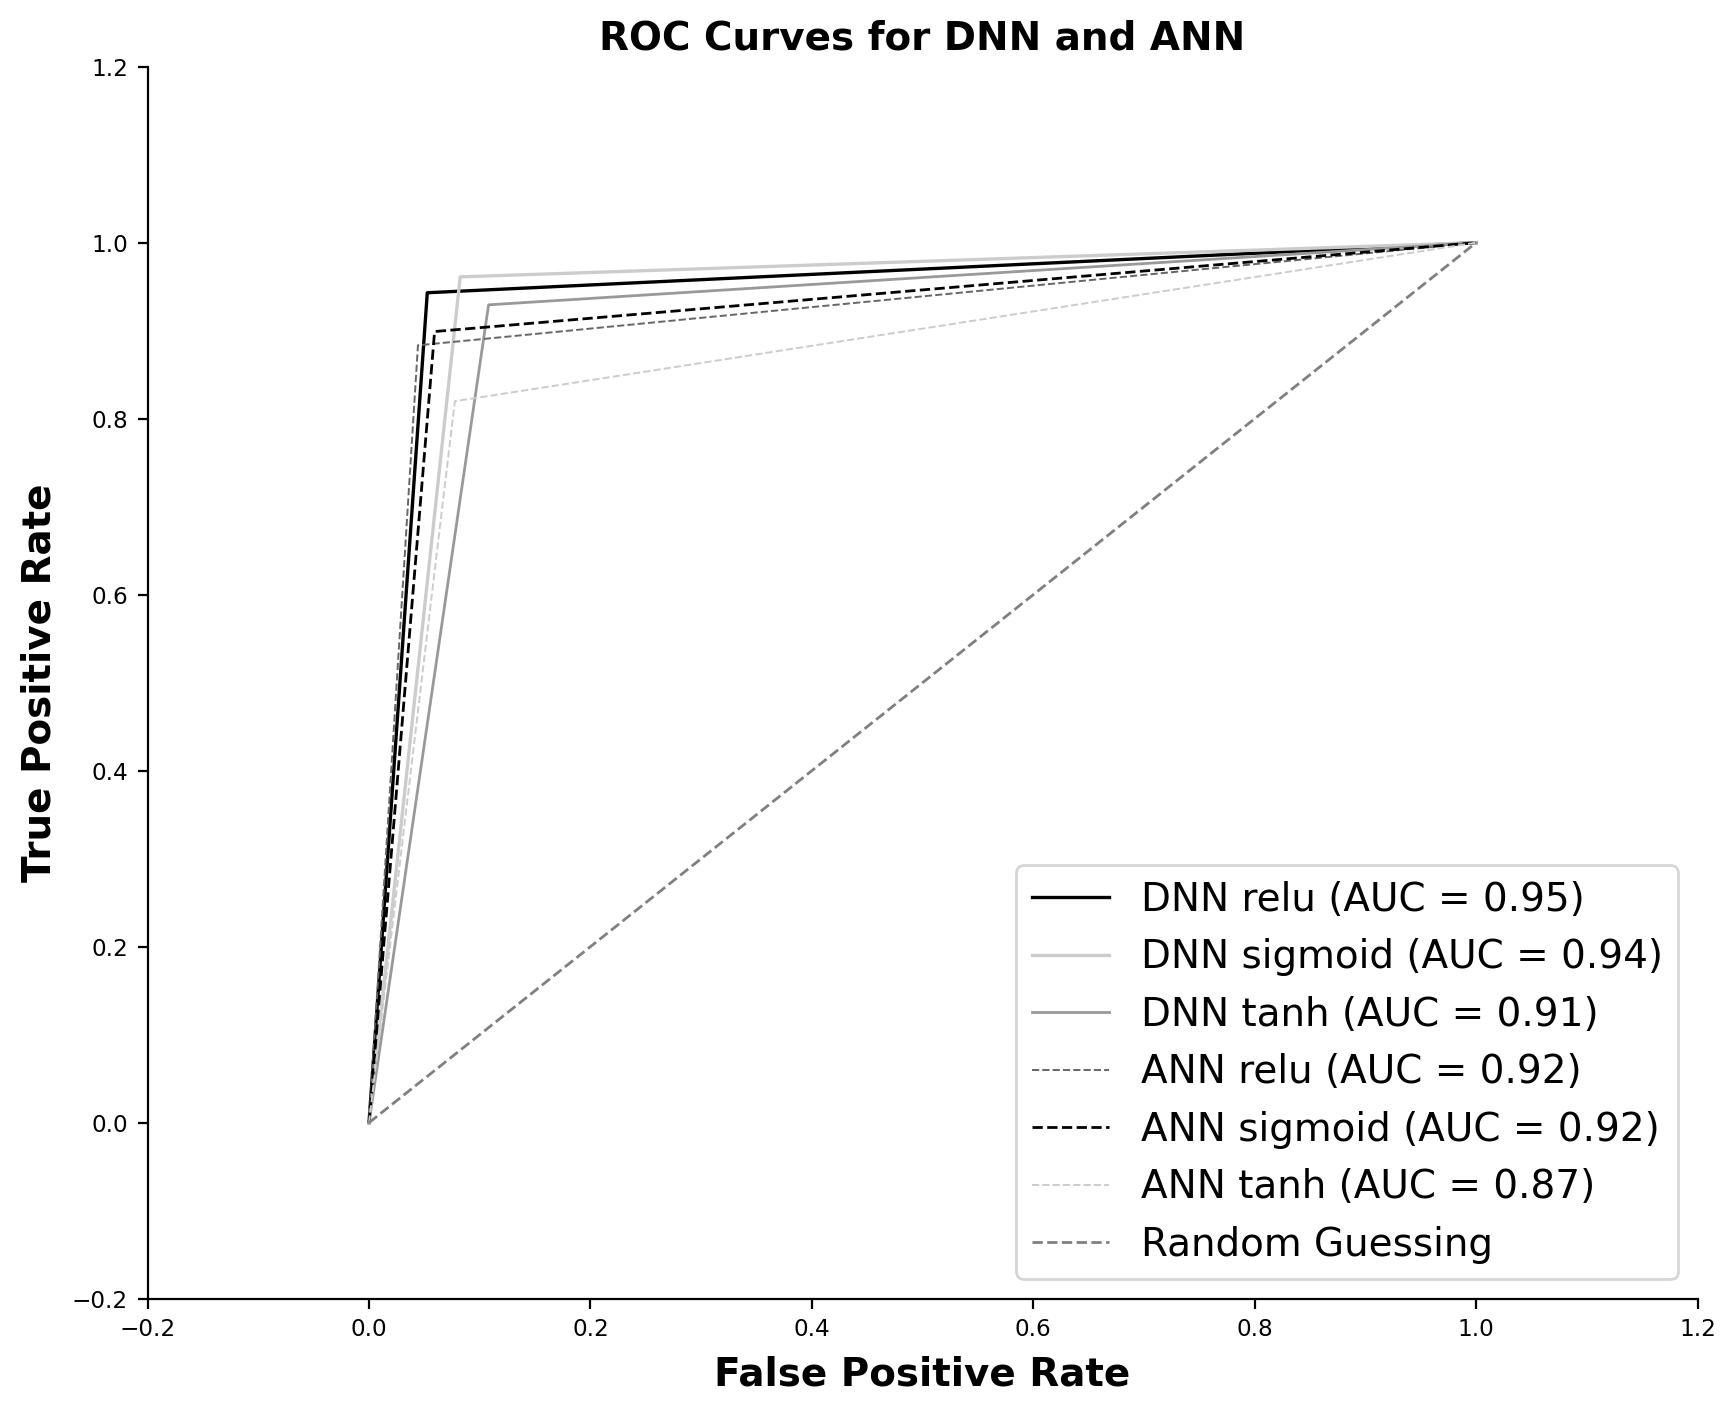

In [12]:
# Define activation functions for DNN
activation_functions_dnn = ["relu", "sigmoid", "tanh"]

# Plot ROC curves for DNN
plt.figure(figsize=(10, 8))
for activation_func, result in results_dnn.items():
    fpr, tpr, _ = roc_curve(y_test, result["y_pred_class_dnn"])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'DNN {activation_func} (AUC = {roc_auc:.2f})')

# Define activation functions for ANN
activation_functions_ann = ["relu", "sigmoid", "tanh"]

# Plot ROC curves for ANN
for activation_func, result in results_ann.items():
    fpr, tpr, _ = roc_curve(y_test, result["y_pred_class_ann"])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ANN {activation_func} (AUC = {roc_auc:.2f})', linestyle='dashed')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves for DNN and ANN', fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()

# Save the plot into the figures folder with the appropriate filename prefix
filename = 'mit_deeplearning_roc_curves.png'
filepath = os.path.join(figures_folder, filename)
plt.savefig(filepath)
plt.show()


# Precision-Recall Curve

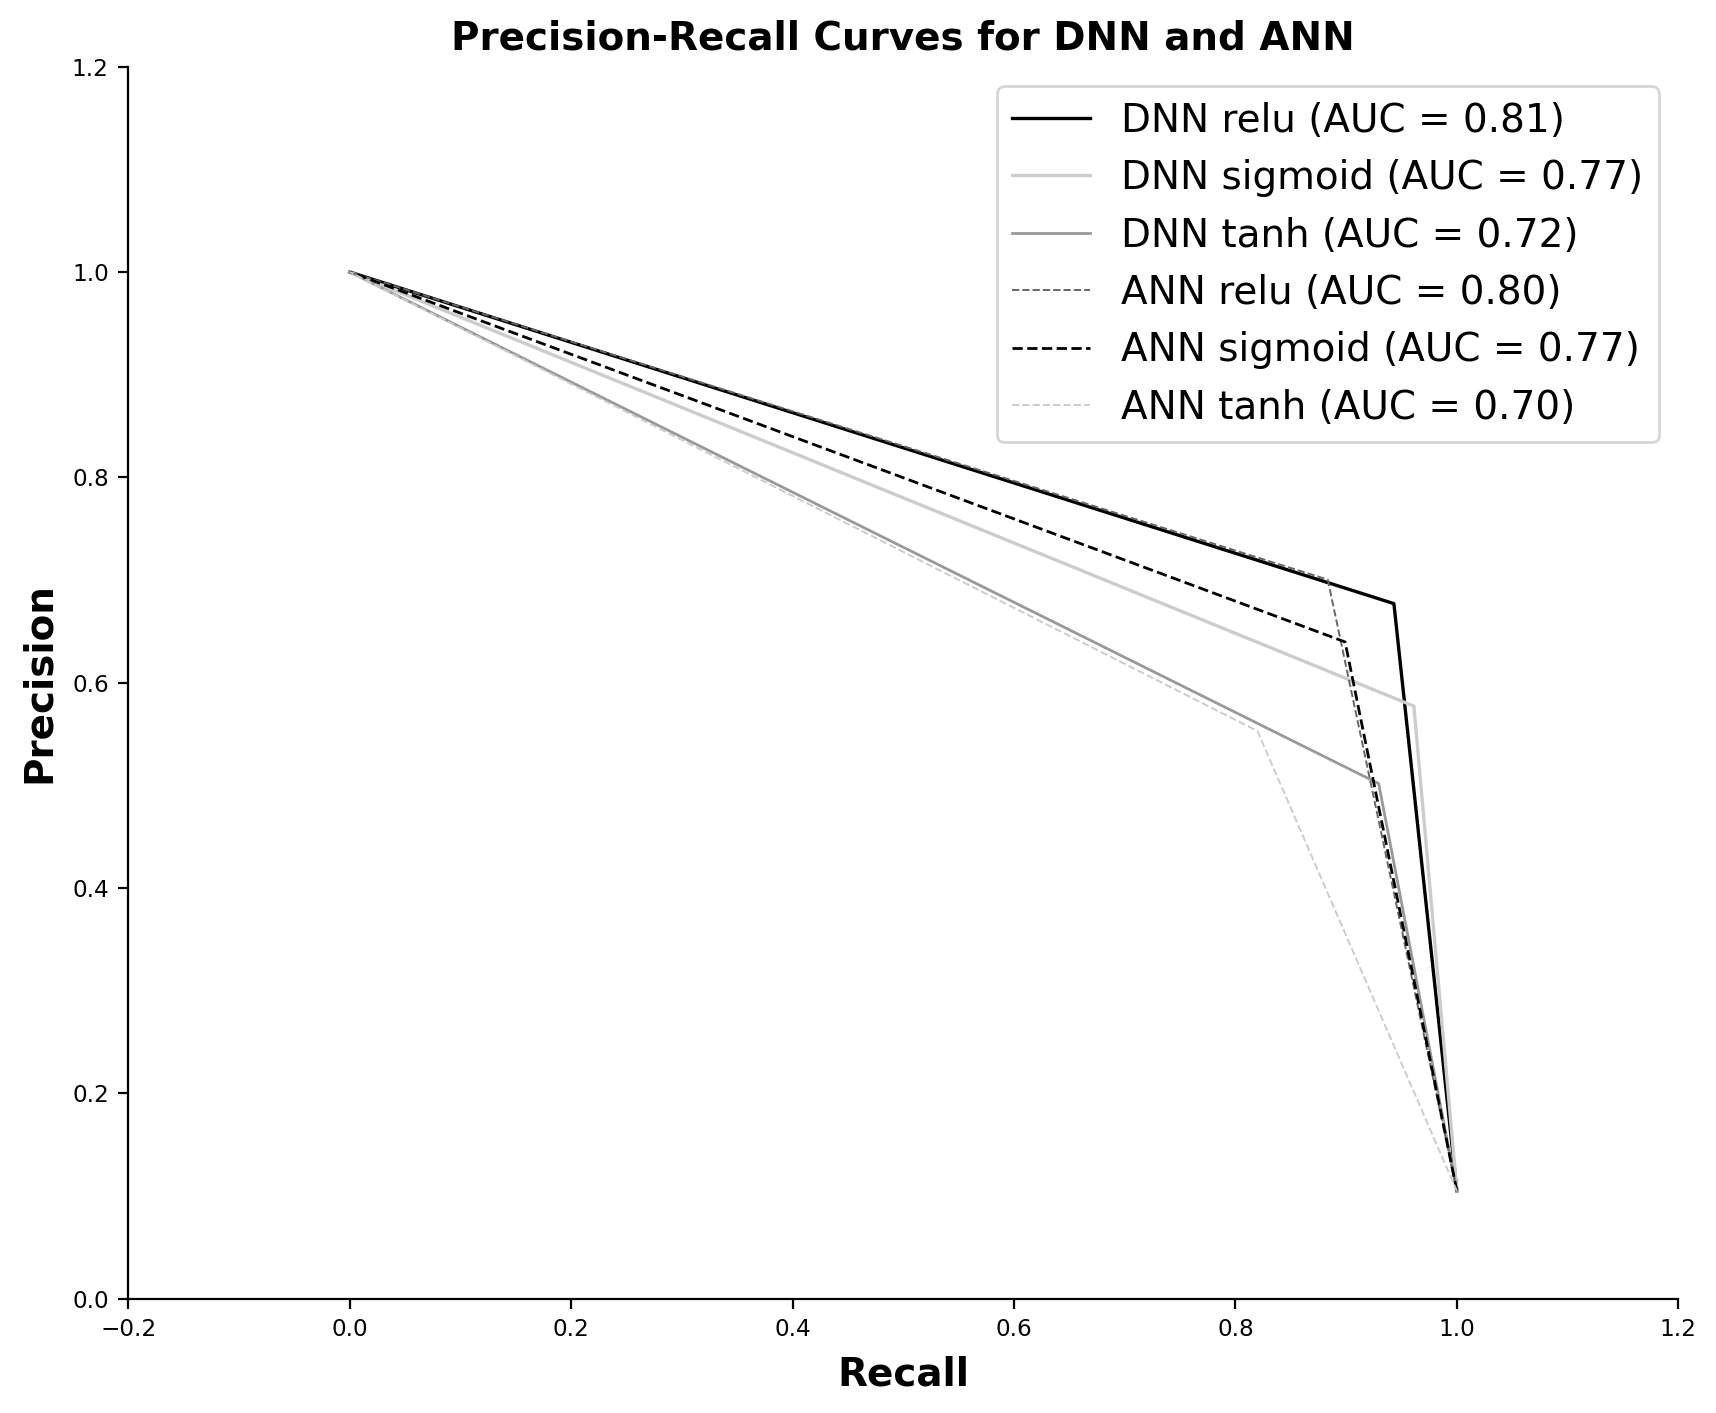

In [ ]:
# Define activation functions for DNN
activation_functions_dnn = ["relu", "sigmoid", "tanh"]

# Plot precision-recall curves for DNN
plt.figure(figsize=(10, 8))
for activation_func, result in results_dnn.items():
    precision, recall, _ = precision_recall_curve(y_test, result["y_pred_class_dnn"])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'DNN {activation_func} (AUC = {pr_auc:.2f})')

# Define activation functions for ANN
activation_functions_ann = ["relu", "sigmoid", "tanh"]

# Plot precision-recall curves for ANN
for activation_func, result in results_ann.items():
    precision, recall, _ = precision_recall_curve(y_test, result["y_pred_class_ann"])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'ANN {activation_func} (AUC = {pr_auc:.2f})', linestyle='dashed')

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curves for DNN and ANN', fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()

# Save the plot into the figures folder with the appropriate filename prefix
filename = 'mit_deeplearning_precision_recall_curves.png'
filepath = os.path.join(figures_folder, filename)
plt.savefig(filepath)
plt.show()


# Model refinement - DNN

In [ ]:
# MODEL 1 - Define the DNN architecture
model_dnn_refine1 = Sequential()
model_dnn_refine1.add(Dense(64, activation='relu', input_shape=(32,)))  # Input layer with ReLU activation
model_dnn_refine1.add(Dense(32, activation='relu'))  # Hidden layer with ReLU activation
model_dnn_refine1.add(Dropout(0.2))  # Dropout regularization to reduce overfitting
model_dnn_refine1.add(Dense(16, activation='relu'))  # Hidden layer with ReLU activation
model_dnn_refine1.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification

# Compile the model
model_dnn_refine1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_dnn_refine1.fit(X_train, y_train, epochs=500, batch_size=100, validation_split=0.1, verbose=0)

# Evaluate the model
y_pred = model_dnn_refine1.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred_class))
print(confusion_matrix(y_test, y_pred_class))
y_pred_class_model_dnn_refine1 = y_pred_class
y_pred_class_model_dnn_refine1 = y_pred_class

630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     18029
           1       0.69      0.97      0.81      2109

    accuracy                           0.95     20138
   macro avg       0.84      0.96      0.89     20138
weighted avg       0.96      0.95      0.96     20138

[[17117   912]
 [   58  2051]]


In [15]:
# MODEL 2 -  Define the DNN architecture
model_dnn_refine2 = Sequential()
model_dnn_refine2.add(Dense(128, activation='relu', input_shape=(32,)))  # Input layer with ReLU activation
model_dnn_refine2.add(Dense(64, activation='relu'))  # Hidden layer with ReLU activation
model_dnn_refine2.add(Dropout(0.3))  # Dropout regularization to reduce overfitting
model_dnn_refine2.add(Dense(32, activation='relu'))  # Hidden layer with ReLU activation
model_dnn_refine2.add(Dense(16, activation='relu'))  # Additional hidden layer with ReLU activation
model_dnn_refine2.add(Dense(8, activation='relu'))  # Additional hidden layer with ReLU activation
model_dnn_refine2.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification

# Compile the model
model_dnn_refine2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_dnn_refine2.fit(X_train, y_train, epochs=500, batch_size=100, validation_split=0.1, verbose=0)

# Evaluate the model
y_pred = model_dnn_refine2.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred_class))
print(confusion_matrix(y_test, y_pred_class))
y_pred_class_model_dnn_refine2 = y_pred_class
y_pred_class_model_dnn_refine2 = y_pred_class

630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     18029
           1       0.71      0.97      0.82      2109

    accuracy                           0.95     20138
   macro avg       0.85      0.96      0.90     20138
weighted avg       0.97      0.95      0.96     20138

[[17178   851]
 [   61  2048]]


In [ ]:

# Define a list of learning rates to experiment with
learning_rates = [0.001, 0.01, 0.1]

# Initialize lists to store results
histories = []
models = []

# Iterate over each learning rate
for lr in learning_rates:
    # Define the model architecture
    model = Sequential([
        Dense(64, activation='relu', input_shape=(32,)),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model with the current learning rate
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=500, batch_size=100, validation_split=0.1, verbose=0)
    
    # Evaluate the model
    _, accuracy = model.evaluate(X_test, y_test)
    print(f"Learning Rate: {lr}, Test Accuracy: {accuracy}")
    
    # Store the model and its history
    models.append(model)
    histories.append(history)

# Print classification report and confusion matrix for the best model
best_model_index = np.argmax([history.history['val_accuracy'][-1] for history in histories])
best_model = models[best_model_index]
y_pred = best_model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")
print(classification_report(y_test, y_pred_class))
print(confusion_matrix(y_test, y_pred_class))

# Save the best model using pickle
model_filename = 'model_best_lr.pkl'
model_filepath = os.path.join(models_folder, model_filename)
with open(model_filepath, 'wb') as f:
    pickle.dump(best_model, f)

# Plot and save confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix - Best Model")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.tight_layout()
fig_name = "mit_confusion_matrix_best_model.png"
fig_path = os.path.join(figures_folder, fig_name)
plt.savefig(fig_path)
plt.close()

630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9484 - loss: 0.2335
Learning Rate: 0.001, Test Accuracy: 0.9487535953521729
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5385 - loss: 0.7149
Learning Rate: 0.01, Test Accuracy: 0.5339159965515137
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1009 - loss: 0.7539
Learning Rate: 0.1, Test Accuracy: 0.1047273799777031
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     18029
           1       0.68      0.98      0.80      2109

    accuracy                           0.95     20138
   macro avg       0.84      0.96      0.89     20138
weighted avg       0.96      0.95      0.95     20138

[[17044   985]
 [   47  2062]]


# Best Model

In [ ]:
# MODEL 1 - Define the DNN architecture
model_dnn_refine1 = Sequential()
model_dnn_refine1.add(Dense(64, activation='relu', input_shape=(32,)))  # Input layer with ReLU activation
model_dnn_refine1.add(Dense(32, activation='relu'))  # Hidden layer with ReLU activation
model_dnn_refine1.add(Dropout(0.2))  # Dropout regularization to reduce overfitting
model_dnn_refine1.add(Dense(16, activation='relu'))  # Hidden layer with ReLU activation
model_dnn_refine1.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification

# Compile the model
model_dnn_refine1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_dnn_refine1.fit(X_train, y_train, epochs=500, batch_size=100, validation_split=0.1, verbose=0)

# Evaluate the model
y_pred = model_dnn_refine1.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred_class))
print(confusion_matrix(y_test, y_pred_class))
y_pred_class_model_dnn_refine1 = y_pred_class
y_pred_class_model_dnn_refine1 = y_pred_class

630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     18029
           1       0.68      0.98      0.80      2109

    accuracy                           0.95     20138
   macro avg       0.84      0.96      0.89     20138
weighted avg       0.96      0.95      0.95     20138

[[17050   979]
 [   48  2061]]


# Model Interpretation - Shap & Lime

PermutationExplainer explainer: 101it [00:11,  2.24it/s]


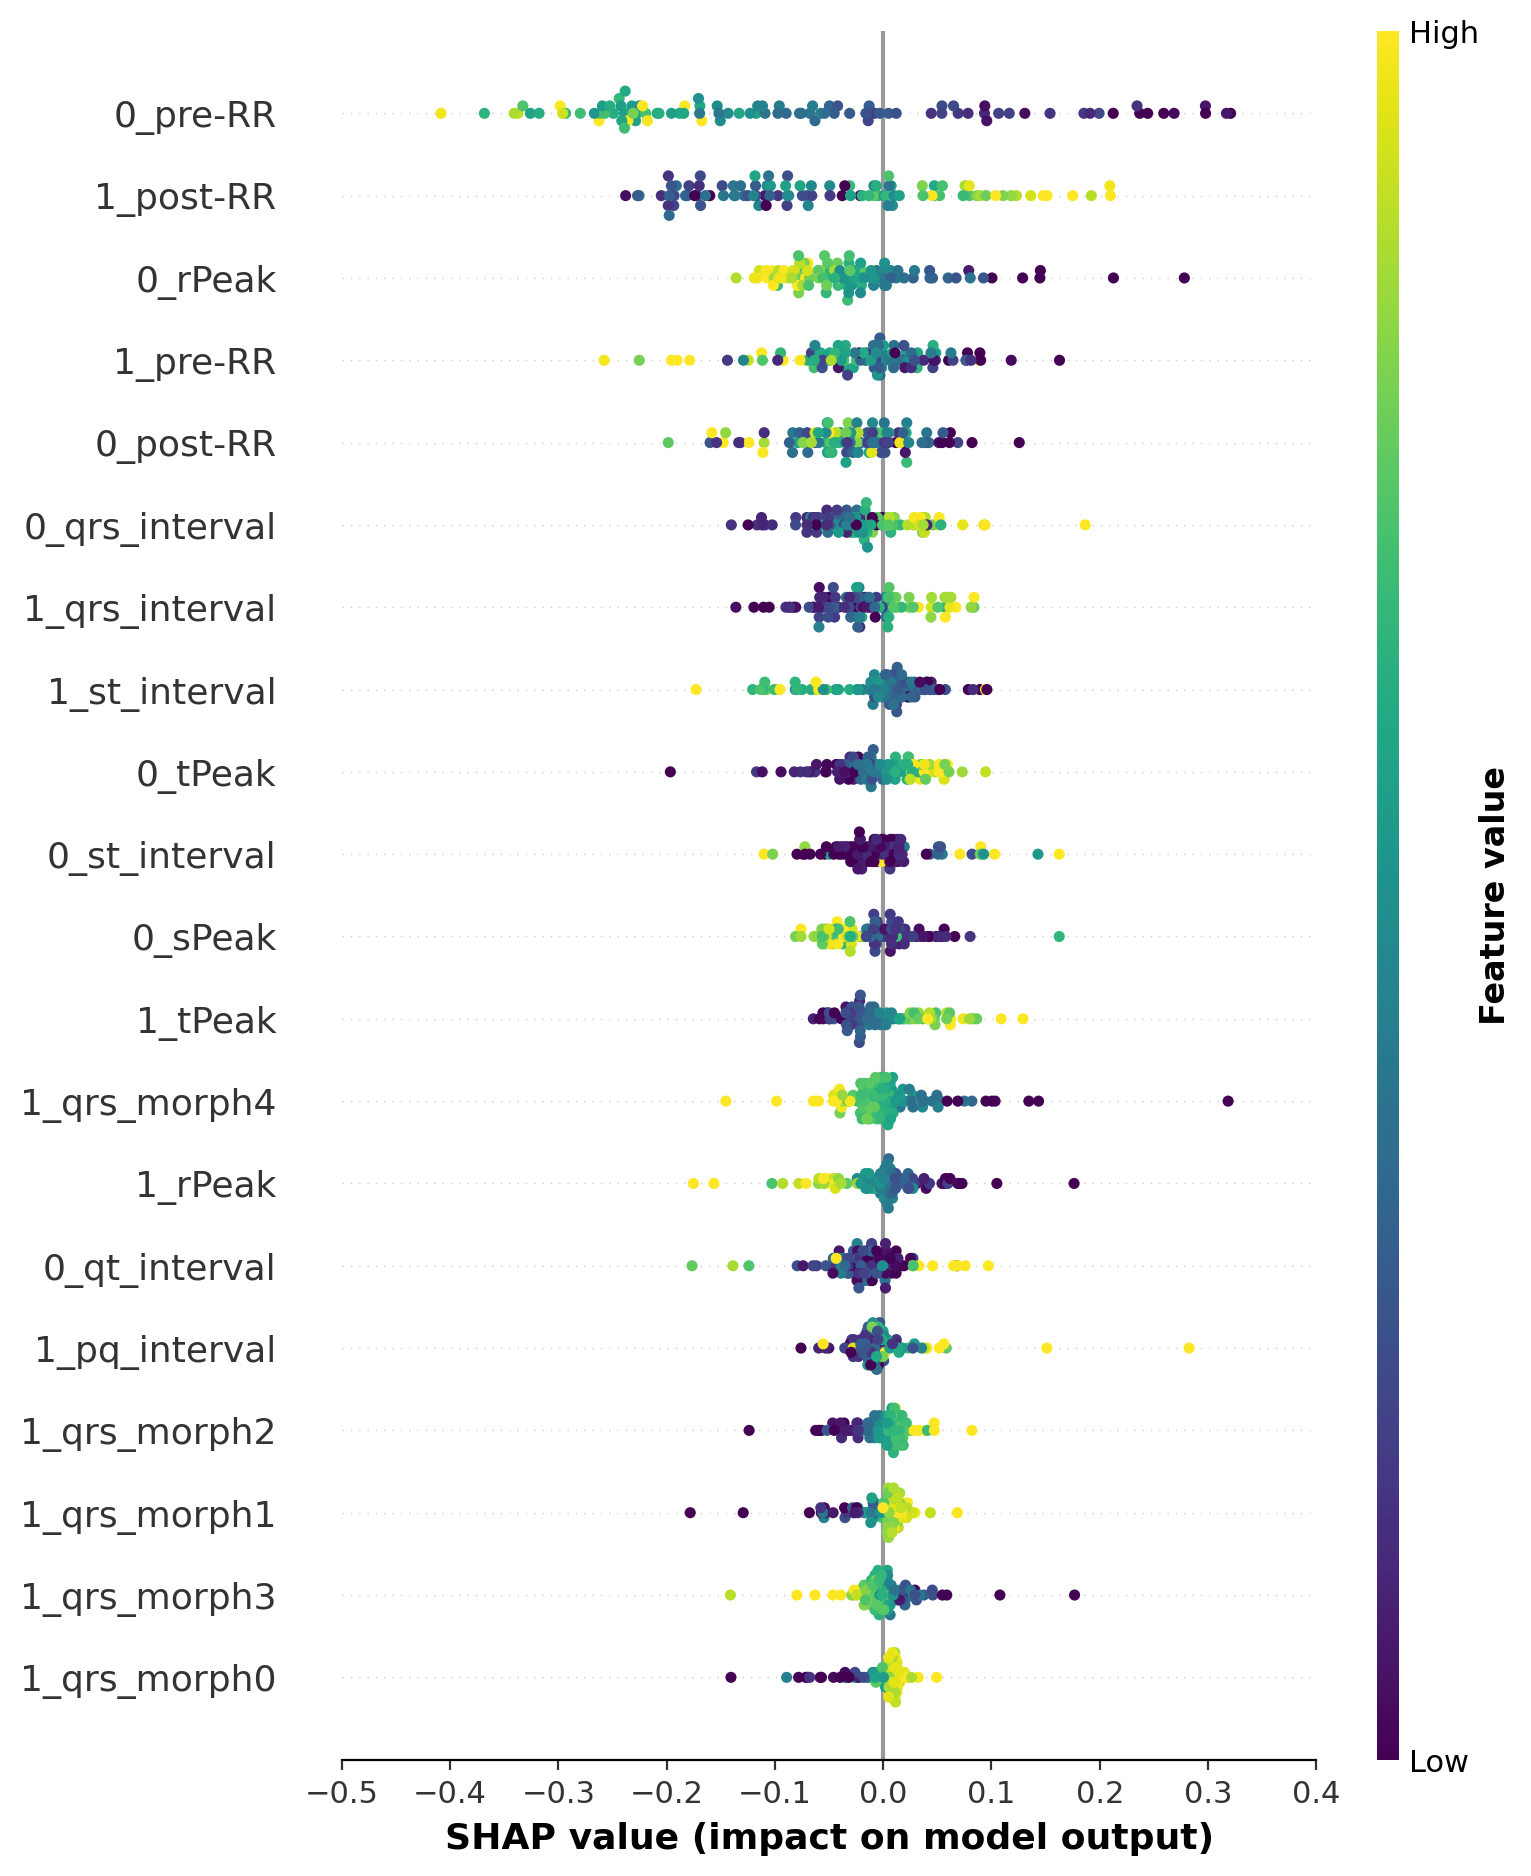

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


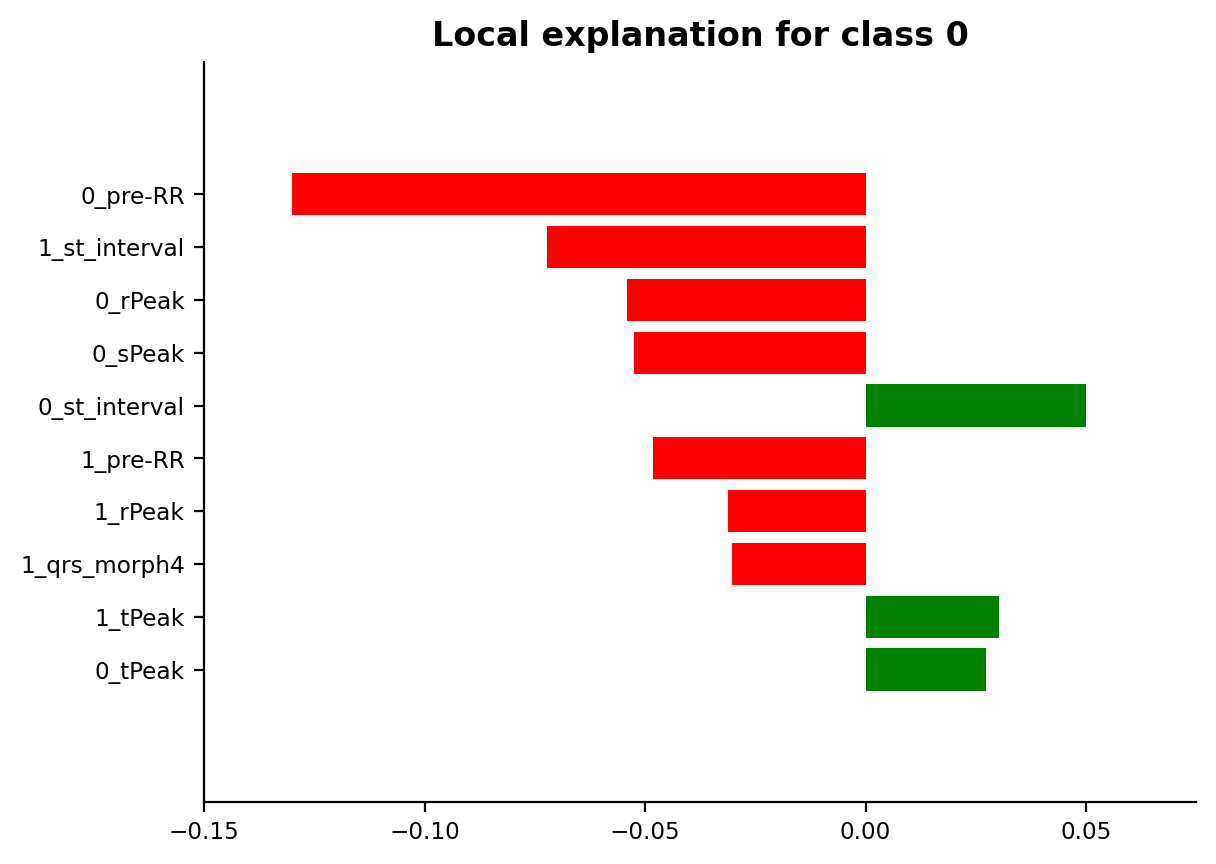

In [20]:
# Create a SHAP explainer
explainer_shap = shap.Explainer(model_dnn_refine1, X_train)

# Calculate SHAP values for a sample of the test data
shap_values = explainer_shap.shap_values(X_test[:100])

# Plot SHAP summary plot with 'viridis' color map
shap.summary_plot(shap_values, features=X_test[:100], feature_names=X_train.columns, cmap='viridis')
plt.title('SHAP Summary Plot')
plt.tight_layout()

# Save SHAP summary plot as PNG
shap_fig_name = 'mit_shap_summary_plot.png'
shap_fig_path = os.path.join(figures_folder, shap_fig_name)
plt.savefig(shap_fig_path)
plt.close()

# Create a Lime explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['0', '1'], discretize_continuous=False)

# Define a function to predict with your model
def model_predict(data):
    return model_dnn_refine1.predict(data)

# Select a sample from the test data
sample_idx = 0  # Change this index as needed
sample = X_test.iloc[sample_idx]

# Generate LIME explanation
explanation = explainer_lime.explain_instance(sample.values, model_predict, labels=[0], num_features=10)

# Plot LIME explanation
explanation.as_pyplot_figure(label=0)
plt.title('LIME Explanation')
plt.tight_layout()

# Save LIME explanation plot as PNG
lime_fig_name = 'mit_lime_explanation.png'
lime_fig_path = os.path.join(figures_folder, lime_fig_name)
plt.savefig(lime_fig_path)
plt.close()

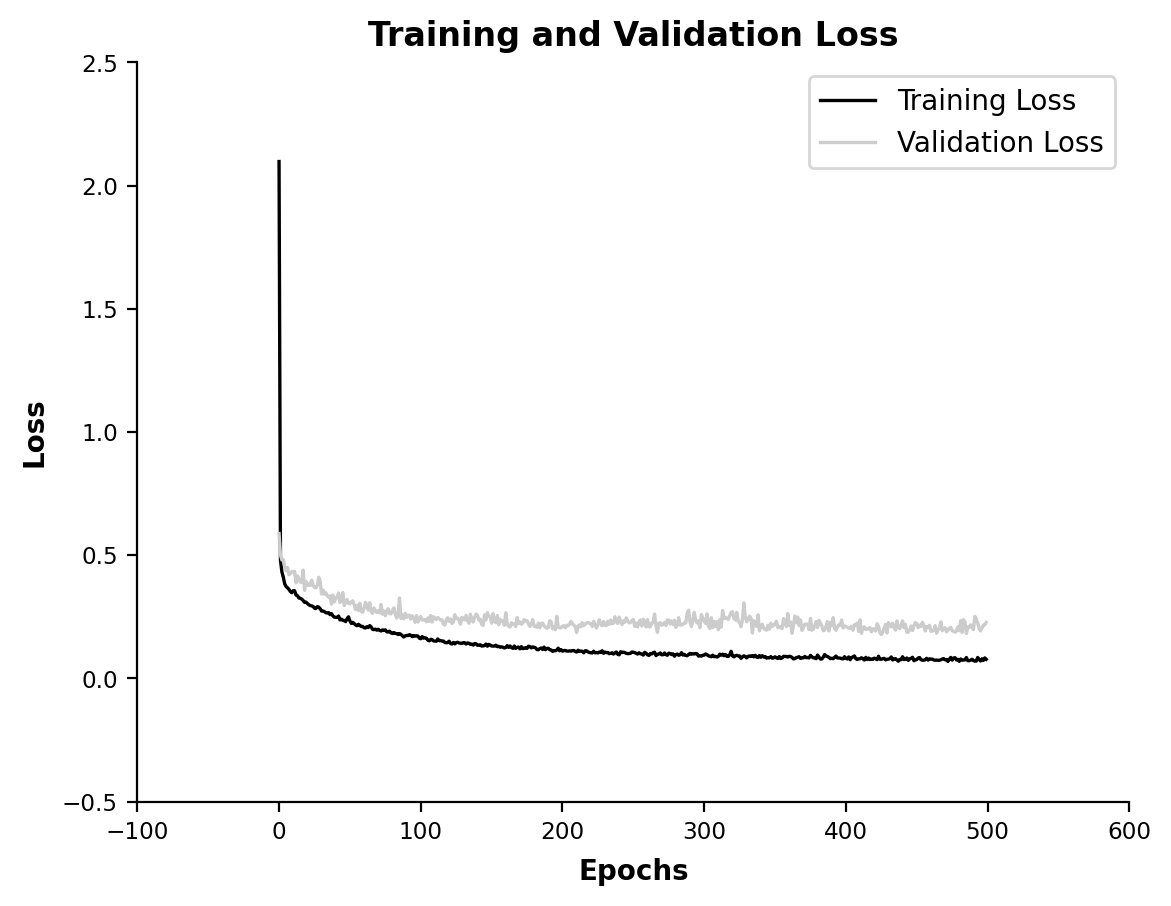

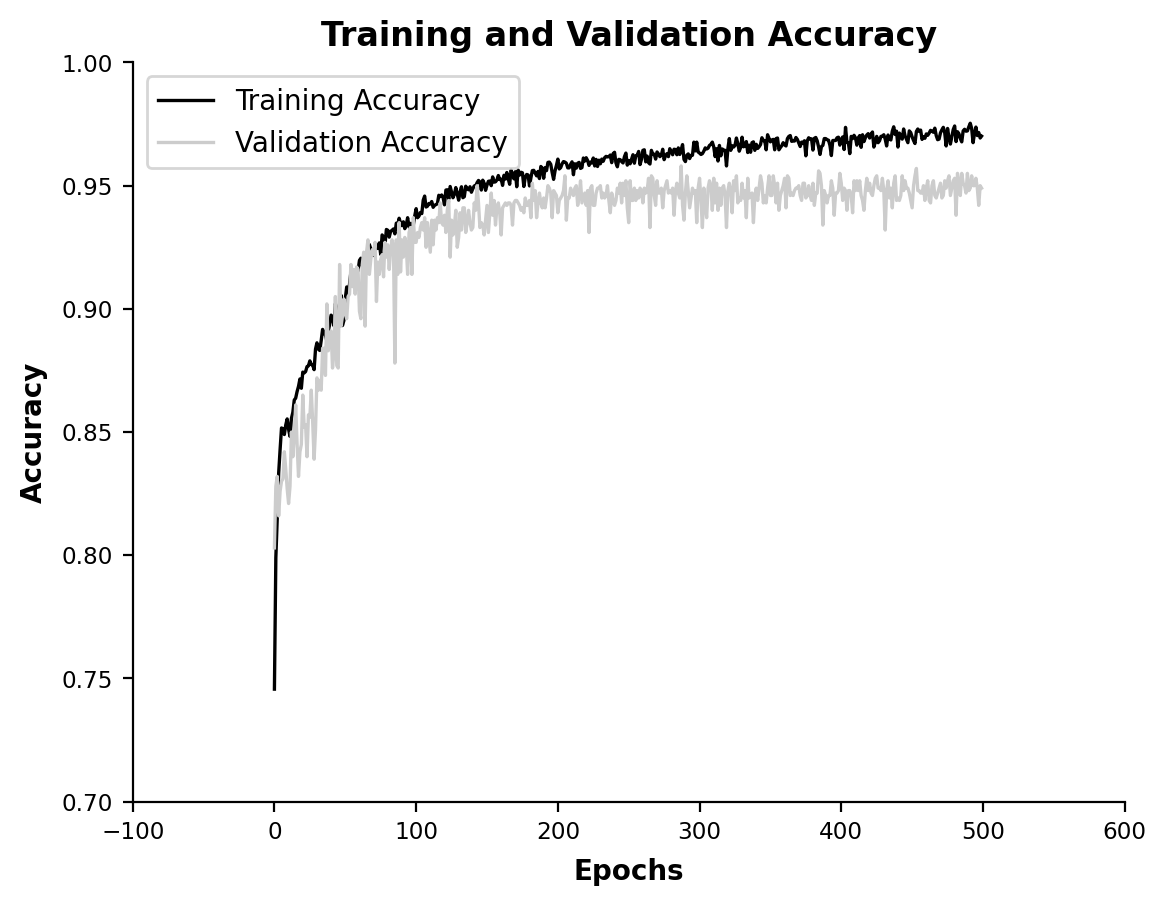

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

# Save training and validation loss plot as PNG
loss_fig_name = 'mit_training_validation_loss.png'
loss_fig_path = os.path.join(figures_folder, loss_fig_name)
plt.savefig(loss_fig_path)
plt.close()

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

# Save training and validation accuracy plot as PNG
accuracy_fig_name = 'mit_training_validation_accuracy.png'
accuracy_fig_path = os.path.join(figures_folder, accuracy_fig_name)
plt.savefig(accuracy_fig_path)
plt.close()

In [22]:
##